![image](https://docs.google.com/uc?export=download&id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d)


<h1><center><b>Support Vector Machines, Modelo Conjuntos y Extracción de Características</b></center></h1>
<h3><center><b>IMÁGENES Y VISIÓN</b></center></h3>
<h8><center>Sebastián Sierra Alarcón - s.sierra11@uniandes.edu.co<center><h8>
<h8><center>Pedro Salazar - p.salazar12@uniandes.edu.co<center><h8>


## **Contenido**
1. [**Objetivos**](#id1)
2. [**Problema**](#id2)
3. [**Importando las librerías necesarias para el laboratorio**](#id3)
4. [**Visualización y Análisis Exploratorio**](#id4)
5. [**Preparación de los Datos**](#id5)
6. [**Modelamiento**](#id6)
7. [**Predicción**](#id7)
8. [**Validación**](#id8)
9. [**Trabajo Asíncrono**](#id9)

## **Objetivos**<a name="id1"></a>
- Familiarizarse con las máquinas de soporte vectorial y los modelos conjuntos.
- Hacer un recorrido básico por las imágenes médicas.
- Extraer características básicas de imágenes.

## **Problema**<a name="id2"></a>
- En un dataset de imágenes varias, buscamos clasificar las imágenes que pertenezcan a dos clases.

## **Notebook Configuration**

In [ ]:
!shred -u setup_colab.py
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/ISIS_4825/setup_colab.py" -O setup_colab.py
import setup_colab as setup
setup.setup_workshop_10()


General Functions Enabled Successfully




Extracting Tar File...
Deleting File...
Dataset Downloaded Successfully
Workshop 10 Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**<a name="id3"></a>

In [ ]:
from utils import general as gen

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             confusion_matrix, f1_score, classification_report )
from sklearn.utils import resample

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
import seaborn as sns

from sklearn.model_selection import (train_test_split, ShuffleSplit, StratifiedShuffleSplit, 
                                     cross_val_score, GridSearchCV)

from skimage import io

from tqdm.auto import tqdm


from sklearn.ensemble import RandomForestClassifier

In [ ]:
def cat_frequencies(labels):
    freq_p = labels.mean()
    freq_n = 1 - freq_p
    return freq_p, freq_n

def reshaped(data, batch=False):
    if batch:
        return np.moveaxis(data.reshape(-1, 3, 32, 32), 1, -1)
    return np.moveaxis(data.reshape(3, 32, 32), 0, -1)

### **Carga de Datos**

In [ ]:
batch_set = []
batch_set.append(gen.unpickle("data/cifar-10-batches-py/data_batch_1"))
batch_set.append(gen.unpickle("data/cifar-10-batches-py/data_batch_2"))
batch_set.append(gen.unpickle("data/cifar-10-batches-py/data_batch_3"))
batch_set.append(gen.unpickle("data/cifar-10-batches-py/data_batch_4"))
batch_set.append(gen.unpickle("data/cifar-10-batches-py/data_batch_5"))

In [ ]:
total_data = []
total_targets = []
for batch in batch_set:
    total_data.append(batch[b"data"])
    total_targets.append(batch[b"labels"])

In [ ]:
total_data = np.array(total_data).reshape(-1, 3072)
total_targets = np.array(total_targets).reshape(-1)
total_data_full = np.array(total_data).reshape(-1, 3072)
total_targets_full = np.array(total_data).reshape(-1, 3072)


In [ ]:
mask = (total_targets == 6) | (total_targets == 7)
total_data = total_data[mask]
total_targets = total_targets[mask]

In [ ]:
total_targets[total_targets == 6] = 0
total_targets[total_targets == 7] = 1

In [ ]:
total_data.shape == total_data_full

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

## **Visualización y Análisis Exploratorio**<a name="id4"></a>
- En este laboratorio usaremos un dataset conocido `CIFAR-10` donde buscaremos clasificar las imágenes pertenecientes a las clases de caballo y rana.

![image](https://miro.medium.com/max/944/1*6XQqOifwnmplS22zCRRVaw.png)

In [ ]:
total_data.shape

(10000, 3072)

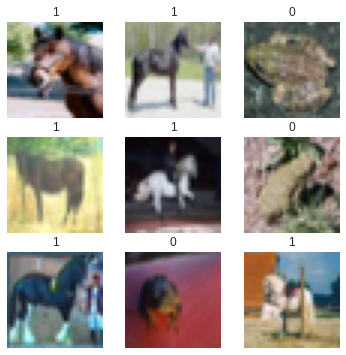

In [ ]:
np.random.seed(5678)
random_sample = np.random.choice(range(total_data.shape[0]), size=9)
gen.visualize_subplot(
    reshaped(total_data[random_sample], batch=True),
    total_targets[random_sample], (3, 3), (6, 6)
)

## **Preparación de los Datos**<a name="id5"></a>

### **Redimensionamiento**

In [ ]:
random_sample = reshaped(total_data[0])

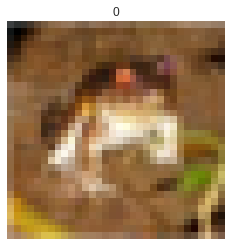

In [ ]:
gen.imshow(random_sample, title=f"{total_targets[0]}")

In [ ]:
total_data.shape

(10000, 3072)

### **Train Set, Validation Set, Test Set**

In [ ]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=1234)

In [ ]:
for train_index, test_index in sss.split(total_data, total_targets):
    full_X_train, X_test = total_data[train_index], total_data[test_index]
    full_y_train, y_test = total_targets[train_index], total_targets[test_index]

In [ ]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=5678)

In [ ]:
for train_index, val_index in sss.split(full_X_train, full_y_train):
    X_train, X_val = full_X_train[train_index], full_X_train[val_index]
    y_train, y_val = full_y_train[train_index], full_y_train[val_index]

In [ ]:
fp, fn = cat_frequencies(total_targets)
fp, fn

(0.5, 0.5)

In [ ]:
fp, fn = cat_frequencies(y_train)
fp, fn

(0.5, 0.5)

In [ ]:
fp, fn = cat_frequencies(y_val)
fp, fn

(0.5, 0.5)

In [ ]:
fp, fn = cat_frequencies(y_test)
fp, fn

(0.5, 0.5)

## **Modelamiento**<a name="id6"></a>
- En esta ocasión haremos uso de las máquinas de soporte vectorial (SVM).

In [ ]:
svm_clf = SVC(kernel="linear")

In [ ]:
%%time
svm_clf.fit(X_train, y_train)

CPU times: user 3min 9s, sys: 134 ms, total: 3min 9s
Wall time: 3min 9s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
%%time
y_pred = svm_clf.predict(X_val)

CPU times: user 16.9 s, sys: 4.95 ms, total: 16.9 s
Wall time: 17 s


In [ ]:
accuracy_score(y_val, y_pred)

0.7152380952380952

In [ ]:
precision_score(y_val, y_pred)

0.7160611854684512

In [ ]:
recall_score(y_val, y_pred)

0.7133333333333334

## **Predicción**<a name="id7"></a>

In [ ]:
np.random.seed(1234)
random_sample = np.random.choice(range(X_test.shape[0]), size=9)
y_pred = svm_clf.predict(X_test[random_sample])

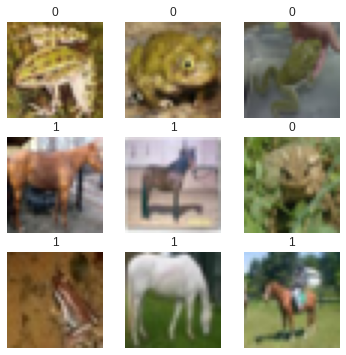

In [ ]:
gen.visualize_subplot(
    reshaped(X_test[random_sample], batch=True),
    y_pred, (3, 3), (6, 6)
)

## **Validación**<a name="id8"></a>

In [ ]:
%%time
y_pred = svm_clf.predict(X_test)

CPU times: user 24.2 s, sys: 4.98 ms, total: 24.2 s
Wall time: 24.3 s


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

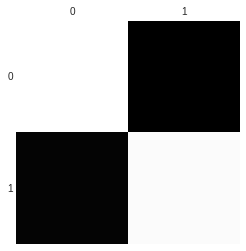

In [ ]:
plt.matshow(conf_matrix, cmap="gray")
plt.show()

In [ ]:
accuracy_score(y_test, y_pred)

0.7536666666666667

In [ ]:
recall_score(y_test, y_pred)

0.7486666666666667

In [ ]:
precision_score(y_test, y_pred)

0.7562289562289563

## **Trabajo Asíncrono**<a name="id9"></a>
1. En primera instancia, utilizar [`GridSearch`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para determinar los mejores valores de los hiperparámetros. Para eso, averiguar sobre los siguientes hiperparámetros:
    - `C`
    - `kernel`

2. Luego, realizar una clasificación multiclase sobre este mismo dataset con todas las clases utilizando un kernel `rbf`. Para el control de la complejidad, realice un [`GridSearch`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) sobre el parámetro de regularización `C` dejando el `kernel` estático. Revisar la documentación de la Support Vector Machine [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

3. Finalmente, Comparar los resultados del mejor modelo obtenido en el segundo punto con un modelo de tipo `RandomForest` y con el modelo `Ensemble` que ud escoja. Para eso, leer el capítulo 7 del libro: **Geron*, A. (2019). Hands-On Machine Learning with Scikit-Learn and TensorFlow. Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media, Inc.** Para la comparación utilice las métricas que se han venido trabajando en el curso y construya una curva de precisión y cobertura (precision-recall curve) para cada modelo.

## **Punto 1** </a>

<p align="justify">
Debido a que el funcionanimento de un SVM se basa en encontrar el hyperplano que separa correctamente todas las observaciones, puede enfrentarse a diferentes situaciones que dificultan su uso y eficiencia. Por un lado, puede suceder como es en la mayoria de los casos que los datos no son linealmente separables. A su vez, en caso de querer separar perfectamente todas las observaciones, el hyperplano va a terminar por ser muy sensible a los datos ocacionando que se pierda un poco de robustez. Tambien puede sucede que se ajuste perfectamente a los datos ocacionando que se pierda generalización por parte del modelo. De esta manera, las SVM tienen un hyperparametro C que tambien es conocido como tunning. <br>
El hyperparámetro C, permite  controlar el número y la severidad de de las violaciones del margen que se definen en el ajuste. Es decir, entre C sea mas grande  los errores se van a penalizar en mayor medida y se va buscar realizar una clasificación perfecta. Entre mas cercana a cero sea C se maneja una menor penalización de los mismos. Este hyperparametro tambien influye en la cantidad de vectores de soporte de nuestro clasificador. Si C es pequeño debido a que el margen del hyperplano es mas grande van a exisitir mas obervaciones que violan el margen que se convirten en vectores de soporte. Mientras que en caso contrario debido a que hay una mayor penalización del error (un menor margen) van a exisitir menores vectores de soporte que sustentan el hyperplano. <br>

Otro hyperparametro de interes es la selección de nuestro Kernel. Debido a que es comun que nuestros datos no sean linealmente separables, se suelen añadir mas dimensiones con el fin de lograr hacer los datos separables. De esta manera toman importancia los kernels nos permiten realizar  operaciones entre vectores en un nuevo espacio espacio y dimension y a su vez se puede volver a pasar el resultado al espacio original. Algunos de los kernel mas comunes son:


*   Kernel Lineal: 

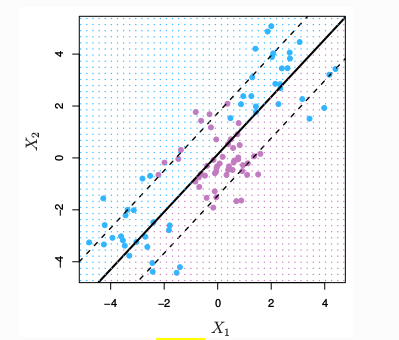


*   Kernel polinómico

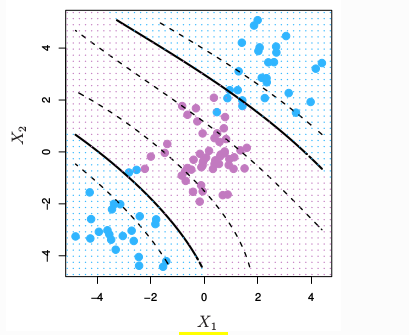

*   Kernel Gaussiano

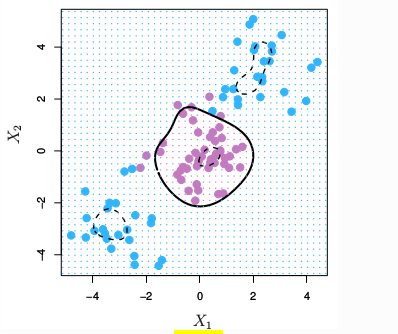

De esta manera, con el fin de encontrar los mejores hyperparámetros para nuestro modelo se proecede a realizar un Grid Seacrh variando C y el kernel a utilizar.

In [ ]:
parameters = {'C':[(0,1),(0,5),(1),(1.5),(2),(5)], 'kernel': ['linear', 'poly','rbf']}

In [ ]:
%%time
svm_clf = SVC()
clf = GridSearchCV(svm_clf, parameters,n_jobs=-1)
clf_results=clf.fit(X_train, y_train)

CPU times: user 1min 5s, sys: 96.7 ms, total: 1min 5s
Wall time: 36min 59s


In [ ]:
clf.best_params_

{'C': 5, 'kernel': 'rbf'}

In [ ]:
clf.best_score_

0.8851020408163265

Se contemplo otro grid search pero esta vez con valores de C mas grandes. Esto debido a que en el grid search pasado pasado se notó que el mejor modelo fue aquel que tuvo un C mayor.

In [ ]:
parameters2 = {'C':[(5),(10),(15)], 'kernel': ['poly','rbf']}

In [ ]:
svm_clf2 = SVC()
clf2 = GridSearchCV(svm_clf2, parameters2,n_jobs=-1)
clf_results2=clf2.fit(X_train, y_train)

In [ ]:
clf2.best_params_

{'C': 5, 'kernel': 'rbf'}

<p align="justify">
De esta manera, podemos ver que a pesar de que los hiperparámetros que mejor se ajustan a nuestro modelo son C igual a 5 y un kernel rbf. En este caso el mejor kernel utilizado para uamnetar la dimensionalidad de nuestro espacio es la función gaussiana radial. El cual a grandes rasgos es un cambio de espacio a uno en donde la salida se define por la distancia desde el origen o algun punto al punto inicial. Sus parámetros son C y gamma, los cuales entre mas aumenten van a ocacionar un overfit y entre mas disminuyan van a causar un underfit

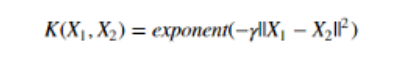

La evaluación del módelo obtenido según nuestras metricas se muestra a continuación:

In [ ]:
y_pred = clf_results2.predict(X_test)

In [ ]:
print(y_pred)

[0 1 0 ... 1 0 0]


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
pd.DataFrame(conf_matrix)

,0,1
0,1335,165
1,174,1326


In [ ]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)
pd.DataFrame(norm_conf_mat)

,0,1
0,0.000,0.11
1,0.116,0.00


Podemos notar que según nuestra matriz de clasificación normalizada, tuvimos cerca de un error del 11% en la clasficiación de ambas clases.

In [ ]:
accuracy_score(y_test, y_pred)

0.887

In [ ]:
recall_score(y_test, y_pred)

0.884

In [ ]:
precision_score(y_test, y_pred)

0.8893360160965795

## **Punto 2** </a>

Para realizar la clasificación multiclase, se procedio a volver a calcular 

In [ ]:
total_data = []
total_targets = []
for batch in batch_set:
    total_data.append(batch[b"data"])
    total_targets.append(batch[b"labels"])
    

In [ ]:
total_data = np.array(total_data).reshape(-1, 3072)[0:10000]
total_targets = np.array(total_targets).reshape(-1)[0:10000]

In [ ]:
print(total_targets)

[6 9 9 ... 1 1 5]


si esta balanceado

In [ ]:
pd.Series(total_targets).value_counts().sort_index()

0    1005
1     974
2    1032
3    1016
4     999
5     937
6    1030
7    1001
8    1025
9     981
dtype: int64

In [ ]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=1234)

for train_index, test_index in sss.split(total_data, total_targets):
    full_X_train, X_test = total_data[train_index], total_data[test_index]
    full_y_train, y_test = total_targets[train_index], total_targets[test_index]

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=5678)

for train_index, val_index in sss.split(full_X_train, full_y_train):
    X_train, X_val = full_X_train[train_index], full_X_train[val_index]
    y_train, y_val = full_y_train[train_index], full_y_train[val_index]


In [ ]:
parametersP2 = {'C':[(4),(2.5),(1)]}

In [ ]:
%%time
svm_grid2 = SVC(kernel="rbf")
clf_grid2 = GridSearchCV(svm_grid2, parametersP2,n_jobs=-1)
clf_grid2__results2=clf_grid2.fit(X_train, y_train)

In [ ]:
clf_grid2.best_params_

{'C': 5}

In [ ]:
clf_grid2.best_score_

0.4477551020408163

In [ ]:
%%time
y_pred = clf_grid2.predict(X_test)

CPU times: user 1min 12s, sys: 9.68 ms, total: 1min 12s
Wall time: 1min 12s


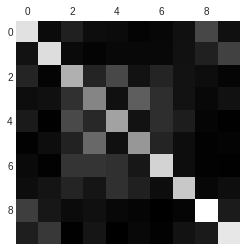

In [ ]:
conf = confusion_matrix(y_test, y_pred)
plt.matshow(conf, cmap='gray')
plt.show()

## **Punto 3** </a>

In [ ]:
total_data = []
total_targets = []
for batch in batch_set:
    total_data.append(batch[b"data"])
    total_targets.append(batch[b"labels"])

In [ ]:
total_data = np.array(total_data).reshape(-1, 3072)
total_targets = np.array(total_targets).reshape(-1)
total_data_full = np.array(total_data).reshape(-1, 3072)
total_targets_full = np.array(total_data).reshape(-1, 3072)

In [ ]:
total_data = np.array(total_data).reshape(-1, 3072)[0:1000]
total_targets = np.array(total_targets).reshape(-1)[0:1000]

In [ ]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=1234)

for train_index, test_index in sss.split(total_data, total_targets):
    full_X_train, X_test = total_data[train_index], total_data[test_index]
    full_y_train, y_test = total_targets[train_index], total_targets[test_index]

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=5678)

for train_index, val_index in sss.split(full_X_train, full_y_train):
    X_train, X_val = full_X_train[train_index], full_X_train[val_index]
    y_train, y_val = full_y_train[train_index], full_y_train[val_index]

In [ ]:
rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pred=rf.predict(X_test)
print ("Classification Report")
print(classification_report(y_test, pred))
print ("Confusion Report")
print(confusion_matrix(y_test, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.46      0.46      0.46       302
           1       0.48      0.44      0.46       292
           2       0.31      0.23      0.27       310
           3       0.33      0.23      0.27       305
           4       0.37      0.43      0.40       300
           5       0.42      0.40      0.41       281
           6       0.41      0.58      0.48       309
           7       0.51      0.41      0.46       300
           8       0.52      0.58      0.55       307
           9       0.47      0.57      0.51       294

    accuracy                           0.43      3000
   macro avg       0.43      0.43      0.43      3000
weighted avg       0.43      0.43      0.43      3000

Confusion Report
[[140  16  20   4  12   9  10   5  64  22]
 [ 12 128   7   9  13  11  15   8  26  63]
 [ 39  14  72  20  54  21  52  16  14   8]
 [ 22  13  28  69  24  54  52  16   5  22]
 [ 18   2  35  18 130  10  49 

opción 2

In [ ]:
rf=RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
pred=rf.predict(X_test)
print ("Classification Report")
print(classification_report(y_test, pred))
print ("Confusion Report")
print(confusion_matrix(y_test, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.45      0.47      0.46       302
           1       0.43      0.38      0.40       292
           2       0.28      0.25      0.27       310
           3       0.29      0.23      0.26       305
           4       0.33      0.39      0.35       300
           5       0.39      0.33      0.36       281
           6       0.39      0.50      0.44       309
           7       0.45      0.35      0.39       300
           8       0.49      0.54      0.51       307
           9       0.47      0.52      0.50       294

    accuracy                           0.40      3000
   macro avg       0.40      0.40      0.39      3000
weighted avg       0.40      0.40      0.39      3000

Confusion Report
[[142  15  12   5  13   8  15   8  66  18]
 [ 12 112   6  13  17  11  14  12  29  66]
 [ 43  13  79  28  55  19  43  13  11   6]
 [ 21  15  31  70  27  45  51  19   5  21]
 [ 19   3  43  19 117  13  48 

In [ ]:
rf=RandomForestClassifier(random_state=0, n_jobs=-1,n_estimators=1000)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
pred=rf.predict(X_val)
print ("Classification Report")
print(classification_report(y_val, pred))
print ("Confusion Report")
print(confusion_matrix(y_val, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.46      0.47       211
           1       0.44      0.40      0.42       205
           2       0.36      0.29      0.32       217
           3       0.30      0.23      0.26       213
           4       0.37      0.44      0.40       210
           5       0.36      0.36      0.36       197
           6       0.42      0.56      0.48       216
           7       0.51      0.39      0.44       210
           8       0.48      0.53      0.51       215
           9       0.45      0.53      0.49       206

    accuracy                           0.42      2100
   macro avg       0.42      0.42      0.41      2100
weighted avg       0.42      0.42      0.41      2100

Confusion Report
[[ 98  14  13   3   8   5   4   3  52  11]
 [ 10  82   2  12  14   5  11  11  13  45]
 [ 27   7  62  19  35  16  22  15   7   7]
 [ 13   5  11  49  17  48  41  11   6  12]
 [  8   3  38   7  92   4  32 

In [ ]:
parameters = {'criterion':['gini','entropy'], 'max_depth': [5,10],'n_estimators':[100,1000]}

In [ ]:
rf=RandomForestClassifier()
clf = GridSearchCV(rf, parameters,n_jobs=-1)
clf_results=clf.fit(X_train, y_train)


In [ ]:
clf_results.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 1000}

In [ ]:
parameters2 = {'criterion':['entropy'], 'max_depth': [10,30],'n_estimators':[1000,2000]}

In [ ]:
rf=RandomForestClassifier()
clf = GridSearchCV(rf, parameters2,n_jobs=-1)
clf_results=clf.fit(X_train, y_train)

In [ ]:
clf_results.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 1000}